In [1]:
import json
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import tripy

from to3D import *
from toOBJ import *
plt.style.use('classic')

In [2]:
loc="moonridge.json"
file=open(loc,"r")
data=json.loads(file.read())

towerRadius=data["features"][0]["towerRadius"]
wallThickness=data["features"][0]["wallThickness"]
roadWidth=data["features"][0]["roadWidth"]

## Walls
Extracting wall data is easy, it's just a contour

We need to make towers at each vertex. Some roads pass through the walls!
=> they always pass exactly ON a vertex of the contour
    => we can search for the presence of the same vertex in road data
    => if found, we need to make room for the road + for the tower.
2 solutions for the contour that we will elevate using the same code as for building:
- use a contour for each segment, use a circle for each vertex
- use one contour for door-to-door segment
- - use road-like way to create the contour of the segments
- - requires to create a part of a circle in the right order for the vertices

I think it's better for customisation to keep it simple: one contour for each segment, one contour for each tower


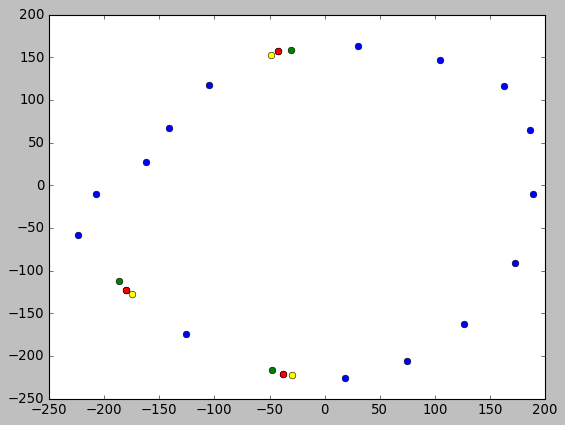

In [23]:

roads=data["features"][2]["geometries"]
walls=data["features"][3]["geometries"]
#for each segment of the wall check if it intersect with one of the roads 
for i in range(len(roads)):
    road=roads[i]["coordinates"]
    xr,yr=np.array(road).transpose()
    #plt.plot(xr,yr)

wallseg=list()
for w in walls:
    for what in w["coordinates"]:
        x,y=np.transpose(what)
        #x=np.append(x,[x[0]])
        #y=np.append(y,[y[0]])
        currentWallSeg=[]
        for i in range(len(x)):
            plt.plot(x[i],y[i], "o", color="blue") #display point
            added=False
            for rc in roads: #iterate roads
                for xri,yri in rc['coordinates']:
                    if x[i]==xri and y[i]==yri:
                        plt.plot(xri,yri,"o",color="red")
                        #detected road. because we started at 1, we can always get x[i-1]
                        xp=x[-1] if i==0 else x[i-1]
                        yp=y[-1] if i==0 else y[i-1]

                        # we want a point that is at roadwidth/2+towerwidth/2 of the initial point, along the segment

                        leng=np.sqrt( (x[i]-xp)**2 + (y[i]-yp)**2 )
                        t=(leng-towerRadius/2-roadWidth/2)/leng
                        xnp1 = x[i]*t+xp*(1-t)
                        ynp1 = y[i]*t+yp*(1-t)
                        plt.plot(xnp1,ynp1,"o",color="yellow")

                        xn=x[0] if i==len(x)-1 else x[i+1]
                        yn=y[0] if i==len(x)-1 else y[i+1]
                        leng=np.sqrt( (x[i]-xn)**2 + (y[i]-yn)**2 )
                        t=(leng-towerRadius-roadWidth/2)/leng
                        xnp2 = x[i]*t+xn*(1-t)
                        ynp2 = y[i]*t+yn*(1-t)
                        plt.plot(xnp2,ynp2,"o",color="green")
                        currentWallSeg.append([xnp1,ynp1])
                        wallseg.append(currentWallSeg)
                        if i==len(x)-1:
                            wallseg[0].insert(0,[xnp2,ynp2])
                        else:
                            currentWallSeg=[[xnp2,ynp2]]
                        added=True
                        
                            
            if not added:
                currentWallSeg.append([x[i],y[i]])

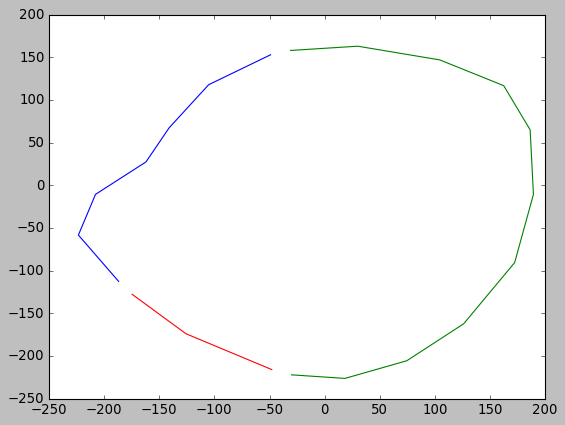

In [24]:
for seg in wallseg:
    xr,yr=np.array(seg).transpose()
    plt.plot(xr,yr)

1.526399316118771 1.4035992591286686


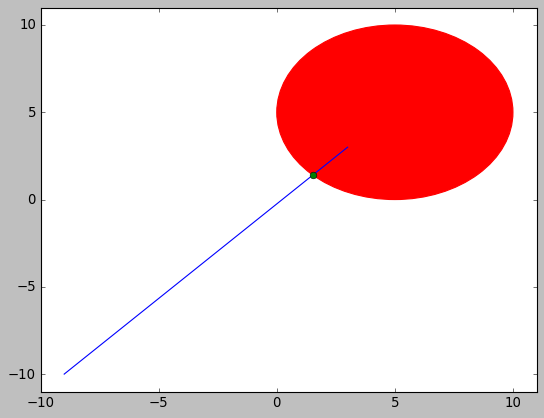

In [25]:
#make a circle centered on x,y
#radius is towerRadius
r=5
cx=5
cy=5
circle=plt.Circle((cx, cy), r, color='r')




x1=-10+1
y1=-10
x2=3
y2=3

fig, ax = plt.subplots()
ax.set_xlim((min(x1,min(x2,cx-r))-1, max(x1,max(x2,cx+r))+1))
ax.set_ylim((min(y1,min(y2,cy-r))-1, max(y1,max(y2,cy+r))+1))

ax.add_artist(circle)
plt.plot([x1,x2],[y1,y2])

 
def lineCircleIntersect(r,cx,cy,x1,y1,x2,y2):
    '''
    line defined by x1,x2,y1,y2
    circle defined by cx,cy,r
    returns None if no intersection
    returns [xr,yr] intersection point
    '''
    dx=(x1-x2)
    dy=(y1-y2)
    a=dx*dx+dy*dy
    b=2*(dx*(x2-cx)+dy*(y2-cy))
    c= cx*cx+cy*cy + x2*x2+y2*y2 -2*cx*x2-2*cy*y2 -r*r
    delta=b*b-4*a*c
    
    if delta<0:
        return [None,None]
    t=(-b+np.sqrt(delta))/(2*a)
    if t>1 or t<0:
        t=(-b-np.sqrt(delta))/(2*a)
    if t>1 or t<0:
        return [None,None]
    else:
        xr=t*(x1-x2)+x2
        yr=t*(y1-y2)+y2
        return [xr,yr]
xr,yr = lineCircleIntersect(r,cx,cy,x1,y1,x2,y2)
print(xr,yr)
if not (xr==None or yr==None):
    plt.plot(xr,yr,"o",color="green")

-2.356194490192345 1.5707963267948966


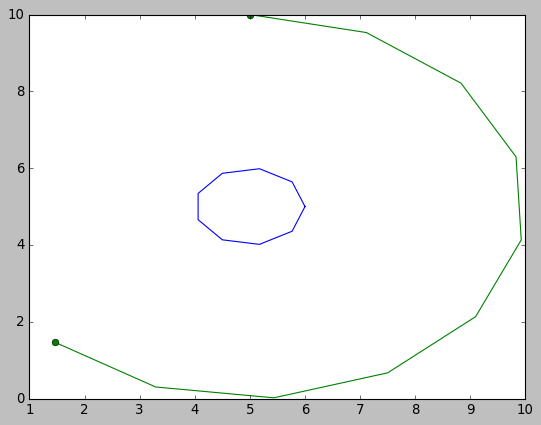

In [26]:
desiredRoundness=24
xr1,yr1 = lineCircleIntersect(5,5,5,-10,-10,3,3)
xr2,yr2 = lineCircleIntersect(5,5,5,0,10,25,10)

startAngle = np.arctan2(yr1-cy, xr1-cx)
endAngle = np.arctan2(yr2-cy, xr2-cx)

print(startAngle,endAngle)

def makeCircle(cx,cy,r,d=10):
    cx,cy=[cx],[cy]
    theta = np.linspace(0, 2*np.pi, d)
    return cx+r * np.cos(theta), cy+r * np.sin(theta)

a,b=makeCircle(5,5,1)
plt.plot(a,b)    
def arcCircleFromArcAngles(t1,t2,r,cx,cy,d=10):
    ratio=abs(t2-t1)/np.pi/2
    theta = np.linspace(t1, t2, d)
    x,y=cx+r * np.cos(theta), cy+r * np.sin(theta)
    return x,y
#x,y=circleFromArc(startAngle,endAngle)
x,y=arcCircleFromArcAngles(startAngle,endAngle,r,cx,cy)
plt.plot(x,y)
#plt.plot(x2,y2)
plt.plot([xr1,xr2],[yr1,yr2],"o",color="green")

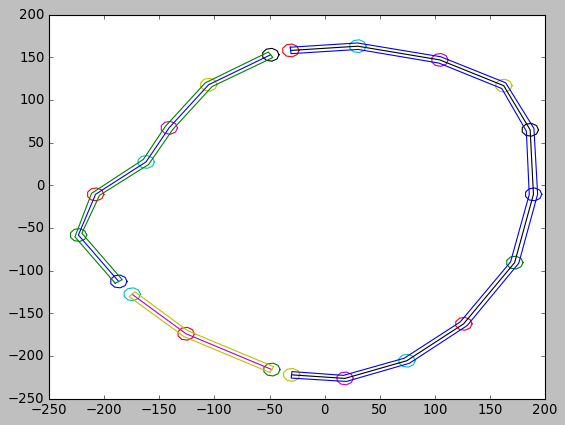

In [27]:
  
for seg in wallseg:
    xr,yr=np.array(seg).transpose()
    x,y=np.transpose(contourFromLine(seg,wallThickness))
    
    circles=[makeCircle(a,b,towerRadius) for a,b in zip(xr,yr)]
    for c in circles:
        plt.plot(c[0],c[1])
    plt.plot(xr,yr)
    plt.plot(x,y)


ValueError: operands could not be broadcast together with shapes (7,) (10,) 

array([ -46.43000856, -127.58889002, -177.31691075, -172.09282894,
       -123.98110998,  -42.82222852,  -46.43000856])